In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import albumentations as A
import time
from tqdm import tqdm
import random

In [21]:
fruit_names = os.listdir('SuperMinDataset/')
data_main_path = 'SuperMinDataset'
mask_main_path = 'Masked SuperMinDataset'

# Form a dictionary to store fruit information
obj_dict = {}
for idx, fruit_name in enumerate(fruit_names, start=1):
    obj_dict[idx] = {
        'folder': fruit_name,
        'longest_min': 150,
        'longest_max': 250,
        'images': sorted(os.listdir(os.path.join('SuperMinDataset', fruit_name))),
        'masks': sorted(os.listdir(os.path.join('Masked SuperMinDataset', fruit_name)))
    }

def choose_img(data_main_path,mask_main_path):
    selected_obj = random.choice(list(obj_dict.keys()))
    selected_folder = obj_dict[selected_obj]['folder']
    selected_image = random.choice(obj_dict[selected_obj]['images'])

    img_path = os.path.join(data_main_path, selected_folder, selected_image)
    mask_path = os.path.join(mask_main_path, selected_folder, selected_image)
    return img_path, mask_path


def get_img_and_mask():
    img_path, mask_path = choose_img(data_main_path, mask_main_path)  # Use the correct paths
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    mask_b = mask[:,:,0] <= 150  # This is boolean mask
    mask = 1 - mask_b.astype(np.uint8)  # Invert the mask
    
    return img, mask


In [22]:
def resize_img(img, desired_max, desired_min=None):
   
    h, w = img.shape[0], img.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = desired_max
    if desired_min:
        shortest_new = desired_min
    else:
        shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Compose([
        A.Sequential([
        A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)
        ], p=1)
    ])

    transformed = transform_resize(image=img)
    img_r = transformed["image"]
        
    return img_r

Shape of the original background image: (1024, 1024, 3)
Shape of the resized background image (desired_max=1920, desired_min=None): (1920, 1920, 3)
Shape of the resized background image (desired_max=1920, desired_min=1080): (1080, 1920, 3)


Text(0.5, 1.0, 'Resized (desired_max=1920, desired_min=1080)')

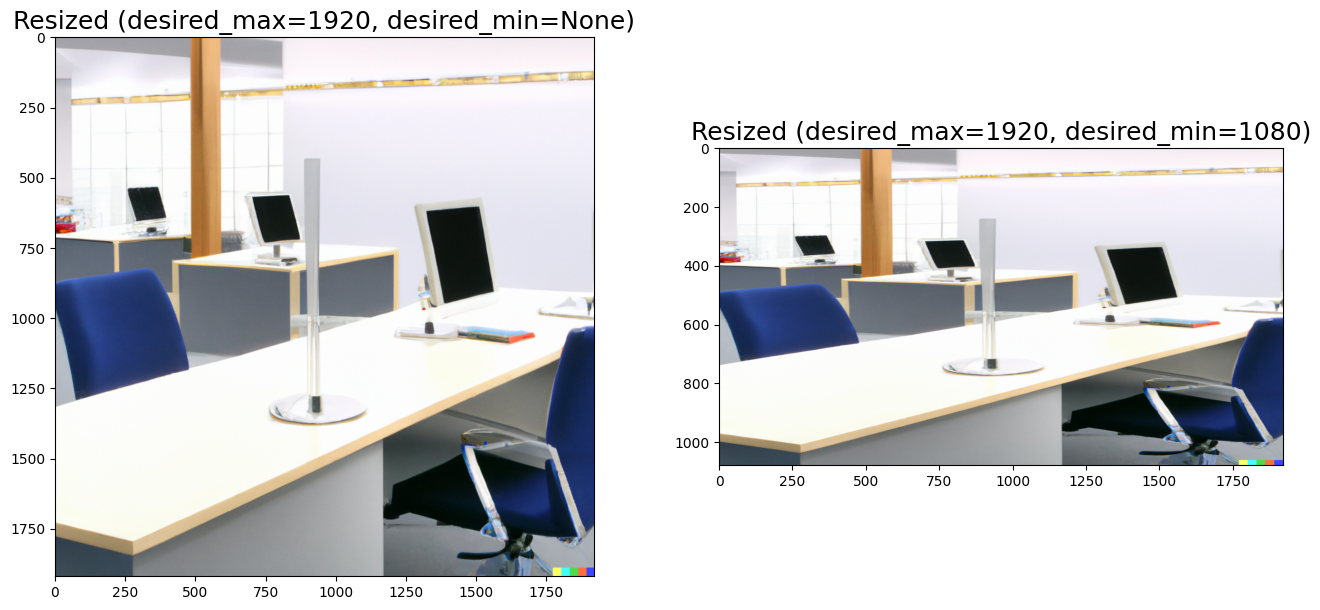

In [23]:
# Let's look how a random background image can be resized with resize_img() function

img_bg_path = 'Data/Back Ground/bg1.png'
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

img_bg_resized_1 = resize_img(img_bg, desired_max=1920, desired_min=None)
img_bg_resized_2 = resize_img(img_bg, desired_max=1920, desired_min=1080)

print("Shape of the original background image:", img_bg.shape)

print("Shape of the resized background image (desired_max=1920, desired_min=None):", img_bg_resized_1.shape)
print("Shape of the resized background image (desired_max=1920, desired_min=1080):", img_bg_resized_2.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_bg_resized_1)
ax[0].set_title('Resized (desired_max=1920, desired_min=None)', fontsize=18)
ax[1].imshow(img_bg_resized_2)
ax[1].set_title('Resized (desired_max=1920, desired_min=1080)', fontsize=18)

In [24]:
def resize_transform_obj(img, mask, longest_min, longest_max, transforms=False):
    if mask is None:  # Eğer maske None ise, hiçbir işlem yapmadan None döndür
        return img, mask
    
    h, w = mask.shape[0], mask.shape[1]
    
    longest_new = np.random.randint(longest_min, longest_max)
    shortest_new = int(min(h, w) * (longest_new / max(h, w)))
    
    transform_resize = A.Resize(longest_new, shortest_new, interpolation=1, always_apply=True)

    transformed_resized = transform_resize(image=img, mask=mask)
    img_t = transformed_resized["image"]
    mask_t = transformed_resized["mask"]
        
    if transforms:
        transformed = transforms(image=img_t, mask=mask_t)
        img_t = transformed["image"]
        mask_t = transformed["mask"]
        
    return img_t, mask_t

transforms_bg_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.ColorJitter(brightness=0.3,
                  contrast=0.3,
                  saturation=0.3,
                  hue=0.07,
                  always_apply=False,
                  p=1),
    A.Blur(blur_limit=(3,15),
           always_apply=False,
           p=0.5)
])

transforms_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                               contrast_limit=0.1,
                               brightness_by_max=True,
                               always_apply=False,
                               p=1)
])


In [25]:
def check_areas(mask_comp, obj_areas, overlap_degree=0.3):
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:-1]
    masks = mask_comp == obj_ids[:, None, None]
    
    ok = True
    
    if len(np.unique(mask_comp)) != np.max(mask_comp) + 1:
        ok = False
        return ok
    
    for idx, mask in enumerate(masks):
        if np.count_nonzero(mask) / obj_areas[idx] < 1 - overlap_degree:
            ok = False
            break
            
    return ok   


In [26]:
import cv2
import random

def choose_bg():
    bg_folder_path = 'Data\Back Ground'

    bg_files = [f for f in os.listdir(bg_folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not bg_files:
        raise ValueError("No valid background images found in the folder.")

    random_bg_file = random.choice(bg_files)
    img_bg_path = os.path.join(bg_folder_path, random_bg_file)
    #print(img_bg_path)
    return img_bg_path

In [27]:
def add_obj(img_comp, mask_comp, img, mask, x, y, idx):
    '''
    img_comp - composition of objects
    mask_comp - composition of objects` masks
    img - image of object
    mask - binary mask of object
    x, y - coordinates where center of img is placed
    Function returns img_comp in CV2 RGB format + mask_comp
    '''
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]
    
    h, w = img.shape[0], img.shape[1]
    
    x = x - int(w/2)
    y = y - int(h/2)
    
    mask_b = mask == 1
    mask_rgb_b = np.stack([mask_b, mask_b, mask_b], axis=2)
    
    if x >= 0 and y >= 0:
    
        h_part = h - max(0, y+h-h_comp) # h_part - part of the image which gets into the frame of img_comp along y-axis
        w_part = w - max(0, x+w-w_comp) # w_part - part of the image which gets into the frame of img_comp along x-axis

        img_comp[y:y+h_part, x:x+w_part, :] = img_comp[y:y+h_part, x:x+w_part, :] * ~mask_rgb_b[0:h_part, 0:w_part, :] + (img * mask_rgb_b)[0:h_part, 0:w_part, :]
        mask_comp[y:y+h_part, x:x+w_part] = mask_comp[y:y+h_part, x:x+w_part] * ~mask_b[0:h_part, 0:w_part] + (idx * mask_b)[0:h_part, 0:w_part]
        mask_added = mask[0:h_part, 0:w_part]
        
    elif x < 0 and y < 0:
        
        h_part = h + y
        w_part = w + x
        
        img_comp[0:0+h_part, 0:0+w_part, :] = img_comp[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_b[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_b)[h-h_part:h, w-w_part:w, :]
        mask_comp[0:0+h_part, 0:0+w_part] = mask_comp[0:0+h_part, 0:0+w_part] * ~mask_b[h-h_part:h, w-w_part:w] + (idx * mask_b)[h-h_part:h, w-w_part:w]
        mask_added = mask[h-h_part:h, w-w_part:w]
        
    elif x < 0 and y >= 0:
        
        h_part = h - max(0, y+h-h_comp)
        w_part = w + x
        
        img_comp[y:y+h_part, 0:0+w_part, :] = img_comp[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_b[0:h_part, w-w_part:w, :] + (img * mask_rgb_b)[0:h_part, w-w_part:w, :]
        mask_comp[y:y+h_part, 0:0+w_part] = mask_comp[y:y+h_part, 0:0+w_part] * ~mask_b[0:h_part, w-w_part:w] + (idx * mask_b)[0:h_part, w-w_part:w]
        mask_added = mask[0:h_part, w-w_part:w]
        
    elif x >= 0 and y < 0:
        
        h_part = h + y
        w_part = w - max(0, x+w-w_comp)
        
        img_comp[0:0+h_part, x:x+w_part, :] = img_comp[0:0+h_part, x:x+w_part, :] * ~mask_rgb_b[h-h_part:h, 0:w_part, :] + (img * mask_rgb_b)[h-h_part:h, 0:w_part, :]
        mask_comp[0:0+h_part, x:x+w_part] = mask_comp[0:0+h_part, x:x+w_part] * ~mask_b[h-h_part:h, 0:w_part] + (idx * mask_b)[h-h_part:h, 0:w_part]
        mask_added = mask[h-h_part:h, 0:w_part]
    
    return img_comp, mask_comp, mask_added

In [28]:
def form_composition(max_objs=7, overlap_degree=0.2, max_attempts_per_obj=10):
    img_comp_bg = choose_bg()  # Choose a background image using the provided function
    img_comp = cv2.imread(img_comp_bg)
    img_comp = cv2.cvtColor(img_comp, cv2.COLOR_BGR2RGB)

    h, w = img_comp.shape[0], img_comp.shape[1]
    mask_comp = np.zeros((h, w), dtype=np.uint8)

    obj_areas = []
    labels_comp = []
    num_objs = np.random.randint(max_objs) + 2
    
    i = 1
    
    for _ in range(1, num_objs):

        obj_idx = np.random.randint(len(obj_dict)) + 1
        
        for _ in range(max_attempts_per_obj):

            imgs_number = len(obj_dict[obj_idx]['images'])
            idx = np.random.randint(imgs_number)
            img_path = obj_dict[obj_idx]['images'][idx]
            mask_path = obj_dict[obj_idx]['masks'][idx]
            img, mask = get_img_and_mask()

            x, y = np.random.randint(w), np.random.randint(h)
            longest_min = obj_dict[obj_idx]['longest_min']
            longest_max = obj_dict[obj_idx]['longest_max']
            img, mask = resize_transform_obj(img,
                                             mask,
                                             longest_min,
                                             longest_max,
                                             transforms=transforms_obj)

            if i == 1:
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                obj_areas.append(np.count_nonzero(mask_added))
                labels_comp.append(obj_idx)
                i += 1
                break
            else:        
                img_comp_prev, mask_comp_prev = img_comp.copy(), mask_comp.copy()
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                ok = check_areas(mask_comp, obj_areas, overlap_degree)
                if ok:
                    obj_areas.append(np.count_nonzero(mask_added))
                    labels_comp.append(obj_idx)
                    i += 1
                    break
                else:
                    img_comp, mask_comp = img_comp_prev.copy(), mask_comp_prev.copy()        
        
    return img_comp, mask_comp, labels_comp, obj_areas


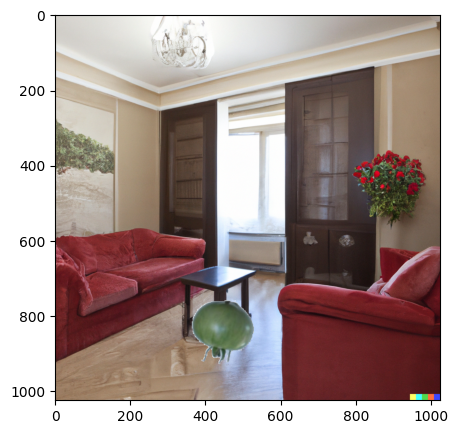

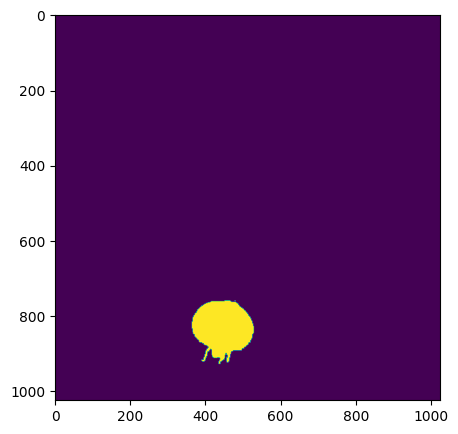

In [29]:
img_comp, mask_comp, labels_comp, obj_areas = form_composition(max_objs=7, overlap_degree=0.2, max_attempts_per_obj=10)
plt.figure(figsize=(5,5))
plt.imshow(img_comp)
plt.figure(figsize=(5,5))
plt.imshow(mask_comp)

In [30]:
print("Labels (classes of the objects) on the composition in order of object's addition:", labels_comp)

Labels (classes of the objects) on the composition in order of object's addition: [2]


In [31]:
obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
masks = mask_comp == obj_ids[:, None, None]

print("Degree of how much area of each object is overlapped:")

for idx, mask in enumerate(masks):
    print(np.count_nonzero(mask) / obj_areas[idx])

Degree of how much area of each object is overlapped:
1.0


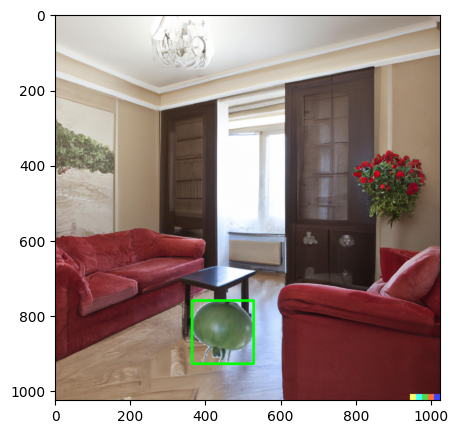

In [32]:
colors = {
    1: (255, 0, 0),
    2: (0, 255, 0),
    3: (0, 0, 255)
}

img_comp_bboxes = img_comp.copy()

obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
masks = mask_comp == obj_ids[:, None, None]

for i in range(len(obj_ids)):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    img_comp_bboxes = cv2.rectangle(img_comp_bboxes,
                                    (xmin, ymin),
                                    (xmax,ymax),
                                    colors[labels_comp[i]],
                                    6)
    
plt.figure(figsize=(5,5))
plt.imshow(img_comp_bboxes)  

# label_colors = {}
# for label in range(1, 132) 131 class olunca, class sayına göre burayı düzenle 
# for label in range(1, 132):
#     r = label % 256
#     g = (label // 256) % 256
#     b = (label // 256 // 256) % 256
#     label_colors[label] = (r, g, b)
# img_comp_bboxes = img_comp.copy()

# obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
# masks = mask_comp == obj_ids[:, None, None]

# for i in range(len(obj_ids)):
#     pos = np.where(masks[i])
#     xmin = np.min(pos[1])
#     xmax = np.max(pos[1])
#     ymin = np.min(pos[0])
#     ymax = np.max(pos[0])
#     label = labels_comp[i]
#     color = label_colors[label]
#     img_comp_bboxes = cv2.rectangle(img_comp_bboxes,
#                                     (xmin, ymin),
#                                     (xmax, ymax),
#                                     color,
#                                     6)
    
# plt.figure(figsize=(5, 5))
# plt.imshow(img_comp_bboxes)


In [33]:
def form_yolo_annotations(mask_comp, labels_comp):
    comp_w, comp_h = mask_comp.shape[1], mask_comp.shape[0]
    
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
    masks = mask_comp == obj_ids[:, None, None]

    annotations_yolo = []
    for i in range(len(labels_comp)):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        xc = (xmin + xmax) / 2
        yc = (ymin + ymax) / 2
        w = xmax - xmin
        h = ymax - ymin

        annotations_yolo.append([labels_comp[i] - 1,
                                 round(xc/comp_w, 5),
                                 round(yc/comp_h, 5),
                                 round(w/comp_w, 5),
                                 round(h/comp_h, 5)])

    return annotations_yolo

In [34]:
annotations_yolo = form_yolo_annotations(mask_comp, labels_comp)
for i in range(len(annotations_yolo)):
    print(' '.join(str(el) for el in annotations_yolo[i]))

1 0.43555 0.82324 0.16016 0.16406


In [35]:
import os

# Klasörleri oluştur
os.makedirs(os.path.join('Dataset', 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join('Dataset', 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join('Dataset', 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join('Dataset', 'labels', 'val'), exist_ok=True)


In [36]:
def generate_dataset(imgs_number, folder, split='train'):
    time_start = time.time()
    for j in tqdm(range(imgs_number)):
        img_comp_bg = choose_bg()
        
        img_comp, mask_comp, labels_comp, _ = form_composition(max_objs=5, overlap_degree=0.2, max_attempts_per_obj=10)

        img_comp = cv2.cvtColor(img_comp, cv2.COLOR_RGB2BGR)
        img_filename = os.path.join(folder, 'images', split, f'{j}.jpg')
        cv2.imwrite(img_filename, img_comp)

        annotations_yolo = form_yolo_annotations(mask_comp, labels_comp)
        label_filename = os.path.join(folder, 'labels', split, f'{j}.txt')
        with open(label_filename, "w") as f:
            for annotation in annotations_yolo:
                f.write(' '.join(str(el) for el in annotation) + '\n')
                
    time_end = time.time()
    time_total = round(time_end - time_start)
    time_per_img = round((time_end - time_start) / imgs_number, 1)
    
    print("Generation of {} synthetic images is completed. It took {} seconds, or {} seconds per image".format(imgs_number, time_total, time_per_img))
    print("Images are stored in '{}'".format(os.path.join(folder, 'images', split)))
    print("Annotations are stored in '{}'".format(os.path.join(folder, 'labels', split)))

In [37]:

generate_dataset(2000, folder='dataset', split='train')
generate_dataset(400, folder='dataset', split='val')

100%|██████████| 2000/2000 [03:37<00:00,  9.21it/s]


Generation of 2000 synthetic images is completed. It took 217 seconds, or 0.1 seconds per image
Images are stored in 'dataset\images\train'
Annotations are stored in 'dataset\labels\train'


100%|██████████| 400/400 [00:34<00:00, 11.53it/s]

Generation of 400 synthetic images is completed. It took 35 seconds, or 0.1 seconds per image
Images are stored in 'dataset\images\val'
Annotations are stored in 'dataset\labels\val'


In [38]:
#generate config.yaml 
import os

class_names = os.listdir('SuperMinDataset')  # Test klasöründeki alt klasör isimlerini al

config_yaml = {
    'train': '/content/yolov5/Dataset/images/train',  # Eğitim görüntüleri dosyası
    'val': '/content/yolov5/Dataset/images/val',      # Doğrulama görüntüleri dosyası
    'names': {i: name for i, name in enumerate(class_names)}  # Sınıf adlarını numaralandırarak eşleştir
}

# YAML dosyasını oluştur
with open('config.yaml', 'w') as yaml_file:
    yaml_file.write('train: {}\n'.format(config_yaml['train']))
    yaml_file.write('val: {}\n'.format(config_yaml['val']))
    yaml_file.write('names:\n')
    for class_id, class_name in config_yaml['names'].items():
        yaml_file.write(f'  {class_id}: {class_name}\n')

print("config.yaml dosyası oluşturuldu.")


config.yaml dosyası oluşturuldu.


In [1]:
#Dataset decreasing
import os
import random
import shutil

data_dir = "Training"  # Veri kümesinin bulunduğu dizin
output_dir = "SuperMinDataset"  # Hedef dizin

selected_fruits = random.sample(os.listdir(data_dir), 3)

for fruit in selected_fruits:
    fruit_dir = os.path.join(data_dir, fruit)
    output_fruit_dir = os.path.join(output_dir, fruit)
    
    os.makedirs(output_fruit_dir, exist_ok=True)
    
    fruit_images = os.listdir(fruit_dir)
    selected_images = random.sample(fruit_images, 400)
    
    for image in selected_images:
        src_path = os.path.join(fruit_dir, image)
        dest_path = os.path.join(output_fruit_dir, image)
        
        shutil.copy(src_path, dest_path)

print("Super Min Dataset oluşturuldu!")


Super Min Dataset oluşturuldu!
